In [206]:
import numpy as np
import pandas as pd

import time

import albumentations as albu
from albumentations.pytorch import ToTensor
import PIL
import cv2 as cv

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam,lr_scheduler

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding, get_model_params

## Load the Dataset

In [4]:
# setup the input data folder
DATA_PATH = './data/'

In [5]:
# load the dataframes with labels
train_labels = pd.read_csv(DATA_PATH + 'train.csv')
test_labels = pd.read_csv(DATA_PATH + 'test.csv')
class_map = pd.read_csv(DATA_PATH + 'class_map.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [7]:
def load_images():
    '''
    Helper function to load all train and test images
    '''
    train_list = []
    for i in range(0,4):
        train_list.append(pd.read_parquet(DATA_PATH + 'train_image_data_{}.parquet'.format(i)))
    train = pd.concat(train_list, ignore_index=True)
    
    test_list = []
    for i in range(0,4):
        test_list.append(pd.read_parquet(DATA_PATH + 'test_image_data_{}.parquet'.format(i)))
    test = pd.concat(test_list, ignore_index=True)
    
    return train, test

In [12]:
train, test = load_images()

## Image Preprocessing and Augmentations

In [117]:
import torchvision

def threshold_image(img):
    '''
    Helper function for thresholding the images
    '''
    gray = PIL.Image.fromarray(np.uint8(img), 'L')
    ret,th = cv.threshold(np.array(gray),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return th

def train_transforms(p=.5):
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        # compose the random cropping and random rotation
        albu.RandomSizedCrop(min_max_height=(int(HEIGHT // 1.1), HEIGHT), height = HEIGHT, width = WIDTH, p=p),
        albu.Rotate(limit=5, p=p)
    ], p=1.0)

## Define the Dataset

Create the custom dataset:

In [163]:
# setup image hight and width
HEIGHT = 137
WIDTH = 236

def get_image(idx, df, labels):
    '''
    Helper function to get the image and label from the training set
    '''
    # get the image id by idx
    image_id = df.iloc[idx].image_id
    # get the image by id
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
    # get the labels
    row = labels[labels.image_id == image_id]
    labels = row['grapheme_root'].values[0], \
    row['vowel_diacritic'].values[0], \
    row['consonant_diacritic'].values[0]
    
    return img, labels

def get_validation(idx, df):
    '''
    Helper function to get the validation image and image_id from the test set
    '''
    # get the image id by idx
    image_id = df.iloc[idx].image_id
    # get the image by id
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
    return img, image_id

class BengaliDataset(Dataset):
    '''
    Create custom Bengali dataset
    '''
    def __init__(self, df_images, transforms, df_labels = None, validation = False):
        self.df_images = df_images
        self.df_labels = df_labels
        self.transforms = transforms
        self.validation = validation

    def __len__(self):
        return len(self.df_images)

    def __getitem__(self, idx):
        if not self.validation:
            img, label = get_image(idx, self.df_images, self.df_labels)
            img = threshold_image(img)
            aug = self.transforms(image = img)
            return TF.to_tensor(aug['image']), label
        else:
            img, image_id = get_validation(idx, self.df_images)
            img = threshold_image(img)
            return TF.to_tensor(img), image_id

Try to get some images and labels from the dataset:

In [185]:
# initialize train dataset
train_dataset = BengaliDataset(train, train_transforms(), train_labels)
sample_trainloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)

[tensor([55, 53, 54, 57, 71]), tensor([1, 1, 1, 0, 2]), tensor([4, 4, 0, 0, 5])]


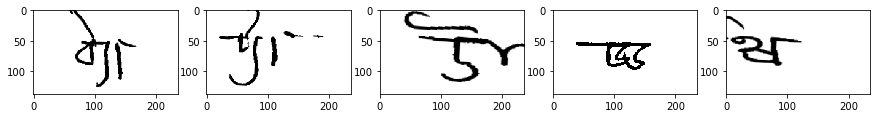

In [193]:
# plot sample train data
for img, labels in sample_trainloader:
    print(labels)
    fig, axs = plt.subplots(1, img.shape[0], figsize=(15,10))
    for i in range(0, img.shape[0]):
        axs[i].imshow(TF.to_pil_image(img[i].reshape(HEIGHT, WIDTH)), cmap='gray')

    break;

## Define the Model

Load the EfficientNet model:

In [240]:
efficientnet_b0 = EfficientNet.from_name('efficientnet-b0')

In [241]:
#efficientnet_b0._conv_stem.in_channels = 1

In [242]:
efficientnet_b0

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [252]:
class BengaliModel(nn.Module):
    def __init__(self, backbone_model):
        super(BengaliModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)
        self.backbone_model = backbone_model
        self.fc1 = nn.Linear(in_features=1000, out_features=168) # grapheme_root
        self.fc2 = nn.Linear(in_features=1000, out_features=11) # vowel_diacritic
        self.fc3 = nn.Linear(in_features=1000, out_features=7) # consonant_diacritic
        
    def forward(self, x):
        # pass through the backbone model
        y = self.conv(x)
        y = self.backbone_model(y)
        
        # multi-output
        grapheme_root = F.softmax(self.fc1(y))
        vowel_diacritic = F.softmax(self.fc2(y))
        consonant_diacritic = F.softmax(self.fc3(y))
        
        return grapheme_root, vowel_diacritic, consonant_diacritic

In [253]:
model = BengaliModel(efficientnet_b0)

## Setup the Training

The hyperparameters:

In [254]:
test_split = 0.2
batch_size = 32
epochs = 10
learning_rate = 0.001
num_workers = 0

Setup the samplers:

In [255]:
dataset_size = len(train_dataset)

indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
testloader = DataLoader(train_dataset, batch_size=4, sampler=test_sampler, num_workers=num_workers)

Setup the loss function and the optimizer:

In [256]:
# set loss function
criterion = nn.NLLLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)

Setup the device:

In [257]:
# setup training device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

Initialize the dataframe to store training statistics:

In [258]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy'
                                      ,'Test loss', 'Test accuracy'])

## Train the Model

In [259]:
def get_accuracy(ps, labels):
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
    return accuracy

In [ ]:
#train the model
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), [label.to(device) for label in labels]
        
        optimizer.zero_grad()
        
        grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(inputs)
        loss = criterion(grapheme_root, labels[0]) + criterion(vowel_diacritic, labels[1]) + \
        criterion(consonant_diacritic, labels[2])
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        train_accuracy += (get_accuracy(grapheme_root, labels[0]) + get_accuracy(vowel_diacritic, labels[1]) + \
                           get_accuracy(consonant_diacritic, labels[2])) 
        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(inputs)
            batch_loss = criterion(grapheme_root, labels[0]) + criterion(vowel_diacritic, labels[1]) + criterion(consonant_diacritic, labels[2])
        
            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            test_accuracy += (get_accuracy(grapheme_root, labels[0]) + get_accuracy(vowel_diacritic, labels[1]) + \
                           get_accuracy(consonant_diacritic, labels[2]))
            
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. ")

    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader),
                                      'Train accuracy': train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader),
                                      'Test accuracy': test_accuracy/len(testloader)}, ignore_index=True)

    running_loss = 0
    model.train()

d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
